In [21]:
import torch
import torchvision
import sys, os
# Install required packages
!{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# Download the checkpoint if it doesn't exist
checkpoint_path = "sam_vit_h_4b8939.pth"
!pip install pillow
!pip install pytesseract
!sudo apt-get install tesseract-ocr
if not os.path.exists(checkpoint_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-soikpg6c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-soikpg6c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [22]:
import requests
from PIL import Image
import io
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime
from sklearn.cluster import DBSCAN
import warnings
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
from scipy.ndimage import label
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from scipy.cluster.hierarchy import fclusterdata
from scipy.cluster.hierarchy import linkage, fcluster
from google.colab.patches import cv2_imshow
import os
import pytesseract
from imutils import contours
from PIL import Image as PILImage
import csv

In [23]:
# Class for edge detection and contour extraction
class EdgeDetector:
    def detect_edges(self, image):
        """
        Detect edges in an image using the Canny edge detection algorithm.

        Parameters:
        image (numpy.ndarray): The input image in which edges are to be detected.

        Returns:
        numpy.ndarray: The binary image with detected edges.
        """
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to the grayscale image to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Detect edges using the Canny algorithm
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Return the image with detected edges
        return edges

    def find_contours(self, edges):
        """
        Find contours in a binary edge-detected image.

        Parameters:
        edges (numpy.ndarray): The binary image with detected edges.

        Returns:
        list: A list of detected contours.
        """
        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Return the list of contours
        return contours

    def extract_centroids(self, contours, min_area=10):
        """
        Extract the centroids of contours with an area larger than a specified minimum.

        Parameters:
        contours (list): A list of detected contours.
        min_area (int): The minimum area threshold for considering a contour.

        Returns:
        list: A list of centroids (x, y) of the contours that meet the area criteria.
        """
        centroids = []

        # Iterate over the contours
        for contour in contours:
            # Check if the contour area is greater than the minimum area
            if cv2.contourArea(contour) > min_area:
                # Calculate the moments of the contour
                M = cv2.moments(contour)

                # Calculate the centroid if the area (m00) is not zero
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])

                    # Append the centroid coordinates to the list
                    centroids.append((cx, cy))

        # Return the list of centroids
        return centroids

In [24]:
# Class for clustering centroids
class Clustering:
    def perform_clustering(self, centroids, eps=10, min_samples=2):
        """
        Perform DBSCAN clustering on a set of centroids.

        Parameters:
        centroids (list): A list of centroid coordinates (x, y) to be clustered.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood. Default is 10.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. Default is 2.

        Returns:
        tuple: A tuple containing:
            - labels (numpy.ndarray): The cluster labels for each point.
            - centers (numpy.ndarray): The coordinates of cluster centers, excluding noise points.
        """
        # Convert the list of centroids to a NumPy array
        centroids = np.array(centroids)

        # Perform DBSCAN clustering on the centroids
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(centroids)

        # Extract the cluster labels assigned by DBSCAN
        labels = db.labels_

        # Get the unique cluster labels (excluding noise points labeled as -1)
        unique_labels = set(labels)

        # Calculate the centers of each cluster by averaging the coordinates of centroids in the same cluster
        centers = [centroids[labels == label].mean(axis=0) for label in unique_labels if label != -1]

        # Return the cluster labels and the coordinates of the cluster centers
        return labels, np.array(centers)

In [25]:
# Class for SAM segmentation
class SamSegmentation:
    def __init__(self, checkpoint, model_type="vit_h"):
        """
        Initialize the SamSegmentation with a model checkpoint and type.

        Parameters:
        checkpoint (str): Path to the model checkpoint.
        model_type (str): Type of the model to be used. Default is "vit_h".
        """
        self.sam = sam_model_registry[model_type](checkpoint=checkpoint)
        self.sam.to(device='cpu')  # Set the model to use CPU
        self.predictor = SamPredictor(self.sam)
        self.ort_session = None  # Initialize the ONNX runtime session to None

    def load_onnx_model(self, onnx_model_path):
        """
        Load an ONNX model for inference.

        Parameters:
        onnx_model_path (str): Path to the ONNX model file.
        """
        self.ort_session = onnxruntime.InferenceSession(onnx_model_path)

    def export_to_onnx(self, onnx_model_path):
        """
        Export the current model to ONNX format.

        Parameters:
        onnx_model_path (str): Path where the ONNX model will be saved.
        """
        onnx_model = SamOnnxModel(self.sam, return_single_mask=True)
        dynamic_axes = {
            "point_coords": {1: "num_points"},
            "point_labels": {1: "num_points"},
        }
        embed_dim = self.sam.prompt_encoder.embed_dim
        embed_size = self.sam.prompt_encoder.image_embedding_size
        mask_input_size = [4 * x for x in embed_size]

        # Create dummy inputs for the ONNX export
        dummy_inputs = {
            "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
            "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
            "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
            "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
            "has_mask_input": torch.tensor([1], dtype=torch.float),
            "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
        }
        output_names = ["masks", "iou_predictions", "low_res_masks"]

        # Suppress warnings during the export
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
            warnings.filterwarnings("ignore", category=UserWarning)
            # Export the model to ONNX format
            with open(onnx_model_path, "wb") as f:
                torch.onnx.export(
                    onnx_model,
                    tuple(dummy_inputs.values()),
                    f,
                    export_params=True,
                    verbose=False,
                    opset_version=17,
                    do_constant_folding=True,
                    input_names=list(dummy_inputs.keys()),
                    output_names=output_names,
                    dynamic_axes=dynamic_axes,
                )

    def segment_image(self, image, cluster_centers):
        """
        Segment an image using the SAM model and provided cluster centers.

        Parameters:
        image (numpy.ndarray): The input image to be segmented.
        cluster_centers (list): List of cluster center coordinates.

        Returns:
        numpy.ndarray: The binary mask of the segmented image.
        """
        self.predictor.set_image(image)
        image_embedding = self.predictor.get_image_embedding().cpu().numpy()

        input_point = cluster_centers
        input_label = np.ones(len(input_point))

        # Prepare inputs for ONNX model
        onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
        onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
        onnx_coord = self.predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
        onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        onnx_has_mask_input = np.zeros(1, dtype=np.float32)

        ort_inputs = {
            "image_embeddings": image_embedding,
            "point_coords": onnx_coord,
            "point_labels": onnx_label,
            "mask_input": onnx_mask_input,
            "has_mask_input": onnx_has_mask_input,
            "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
        }

        # Run inference using ONNX runtime session
        masks, _, low_res_logits = self.ort_session.run(None, ort_inputs)
        masks = masks > self.predictor.model.mask_threshold
        return masks

    def calculate_remaining_clusters(self, mask):
        """
        Calculate remaining clusters after filtering out small components.

        Parameters:
        mask (numpy.ndarray): The binary mask of the segmented image.

        Returns:
        tuple: A tuple containing:
            - filtered_mask (numpy.ndarray): The binary mask after filtering.
            - remaining_pieces (int): The number of remaining clusters.
        """
        labeled_mask, num_pieces = label(mask)
        area_threshold = 2000  # Specify the threshold area here

        # Filter out small components
        for component in range(1, num_pieces + 1):
            component_mask = labeled_mask == component
            if np.sum(component_mask) < area_threshold:
                labeled_mask[component_mask] = 0

        filtered_mask = labeled_mask > 0
        _, remaining_pieces = label(filtered_mask)
        return filtered_mask, remaining_pieces

    def show_mask(self, mask, ax):
        """
        Display a binary mask on an axis.

        Parameters:
        mask (numpy.ndarray): The binary mask to be displayed.
        ax (matplotlib.axes.Axes): The axis on which to display the mask.
        """
        color = np.array([30/255, 144/255, 255/255, 0.9])  # RGBA color for the mask
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1) * 255
        mask_image = mask_image.astype(np.uint8)
        ax.imshow(mask_image)

    def show_results(self, image, masks, cluster_centers, saving_path):
        """
        Show and save the results of segmentation.

        Parameters:
        image (numpy.ndarray): The input image.
        masks (numpy.ndarray): The binary mask of the segmented image.
        cluster_centers (list): List of cluster center coordinates.
        saving_path (str): Path where the result image will be saved.
        """
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        filtered_mask, _ = self.calculate_remaining_clusters(masks)
        self.show_mask(filtered_mask, plt.gca())
        plt.axis('off')
        plt.savefig(saving_path)
        plt.show()

In [26]:
# Class for applying mathematical morphology operations on an image
class MathematicalMorphology:
    def __init__(self, image_path):
        """
        Initialize the MathematicalMorphology with the path to an image.

        Parameters:
        image_path (str): The file path to the input image.
        """
        self.image_path = image_path
        self.image = cv2.imread(self.image_path)  # Read the image from the file path

    def apply_morphology(self):
        """
        Apply morphological operations to the input image to fill holes and remove noise.

        Returns:
        numpy.ndarray: The processed image after morphological operations.
        """
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

        # Create a kernel for morphological operations
        kernel = np.ones((5, 5), np.uint8)

        # Apply the morphological close operation to fill small holes
        closed_image = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Invert the colors of the closed image
        inverted_image = cv2.bitwise_not(closed_image)

        # Copy the inverted image for flood filling
        flood_filled_image = inverted_image.copy()

        # Get the dimensions of the inverted image
        h, w = inverted_image.shape

        # Create a mask for flood filling (note the mask size is 2 pixels larger than the image)
        mask = np.zeros((h+2, w+2), np.uint8)

        # Apply flood fill starting from the top-left corner (0, 0)
        cv2.floodFill(flood_filled_image, mask, (0, 0), 255)

        # Invert the flood-filled image
        flood_filled_image = cv2.bitwise_not(flood_filled_image)

        # Combine the original closed image with the flood-filled inverted image to fill holes
        filled_image = closed_image | flood_filled_image

        # Return the processed image
        return filled_image

In [27]:
# Class to process an image and segment it into paragraphs using bounding boxes
class ImageProcessor:
    def __init__(self, image, mask_image):
        """
        Initialize the ImageProcessor with the image and mask image.

        Parameters:
        image (numpy.ndarray): The original input image.
        mask_image (numpy.ndarray): The mask image for segmentation.
        """
        self.mask_image = mask_image
        self.image = image

    def process_image(self):
        """
        Process the image to find and draw bounding boxes around paragraphs.

        Returns:
        list: A list of final bounding boxes.
        """
        if self.image is None:
            raise ValueError("Failed to load image from the input")

        # Ensure mask_image has the correct data type and number of channels
        if self.mask_image.dtype != np.uint8:
            self.mask_image = (self.mask_image * 255).astype(np.uint8)

        if len(self.mask_image.shape) == 2:  # Grayscale image
            self.mask_image = cv2.cvtColor(self.mask_image, cv2.COLOR_GRAY2BGR)
        elif self.mask_image.shape[2] == 4:  # BGRA image
            self.mask_image = cv2.cvtColor(self.mask_image, cv2.COLOR_BGRA2BGR)

        # Convert mask_image to grayscale
        gray_image = cv2.cvtColor(self.mask_image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to the grayscale image
        blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

        # Perform edge detection using Canny
        edges = cv2.Canny(blurred_image, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Calculate bounding boxes for each contour
        bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
        bounding_boxes_array = np.array(bounding_boxes)

        # Cluster bounding boxes based on distance threshold
        threshold_distance = 50  # Adjust this threshold based on your image
        clusters = fclusterdata(bounding_boxes_array, t=threshold_distance, criterion="distance")

        # Group bounding boxes by clusters and merge them
        grouped_boxes = []
        for cluster_id in np.unique(clusters):
            cluster_boxes = bounding_boxes_array[clusters == cluster_id]
            merged_box = self.merge_bounding_boxes(cluster_boxes)
            grouped_boxes.append(merged_box)

        # Filter out inner boxes
        filtered_boxes = self.filter_inner_boxes(grouped_boxes)

        # Merge overlapping boxes
        final_boxes = self.merge_overlapping_boxes(filtered_boxes)

        # Draw bounding boxes around each paragraph
        segmented_image = self.image.copy()
        for box in final_boxes:
            x, y, w, h = box
            cv2.rectangle(segmented_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display the segmented image
        cv2_imshow(segmented_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Convert segmented_image from NumPy array to PIL Image
        segmented_image_pil = PILImage.fromarray(segmented_image)

        # Placeholder for OCR text extraction results
        ocr_results = []
        for box in final_boxes:
            # Extract coordinates of the box
            x1, y1, x2, y2 = box

            # Crop the image to the box region
            cropped_image = segmented_image_pil.crop((x1, y1, x1 + x2, y1 + y2))

            # Perform OCR on the cropped image
            extracted_text = pytesseract.image_to_string(cropped_image)

            # Append the extracted text along with box coordinates
            ocr_results.append({
                'box_coordinates': (x1, y1, x2, y2),
                'text': extracted_text.strip()  # Remove leading/trailing whitespace
            })

        return final_boxes,ocr_results

    def merge_bounding_boxes(self, boxes):
        """
        Merge multiple bounding boxes into a single bounding box.

        Parameters:
        boxes (list): List of bounding boxes to be merged.

        Returns:
        tuple: A single bounding box that encompasses all input boxes.
        """
        x_min = min([box[0] for box in boxes])
        y_min = min([box[1] for box in boxes])
        x_max = max([box[0] + box[2] for box in boxes])
        y_max = max([box[1] + box[3] for box in boxes])
        return (x_min, y_min, x_max - x_min, y_max - y_min)

    def filter_inner_boxes(self, boxes, tolerance=0.1):
        """
        Filter out boxes that are within other boxes.

        Parameters:
        boxes (list): List of bounding boxes.
        tolerance (float): Tolerance for considering a box within another. Default is 0.1.

        Returns:
        list: Filtered list of bounding boxes.
        """
        filtered_boxes = []
        for i, box in enumerate(boxes):
            x, y, w, h = box
            outer_box = False
            for j, other_box in enumerate(boxes):
                if i != j:
                    ox, oy, ow, oh = other_box
                    # Expand the other_box boundaries by tolerance
                    ox_min = ox - tolerance
                    oy_min = oy - tolerance
                    ox_max = ox + ow + tolerance
                    oy_max = oy + oh + tolerance

                    # Check if box is within other_box with tolerance
                    if x >= ox_min and y >= oy_min and x + w <= ox_max and y + h <= oy_max:
                        outer_box = True
                        break
            if not outer_box:
                filtered_boxes.append(box)
        return filtered_boxes

    def merge_overlapping_boxes(self, boxes, overlap_threshold=0.01):
        """
        Merge overlapping bounding boxes into larger boxes.

        Parameters:
        boxes (list): List of bounding boxes.
        overlap_threshold (float): Threshold for considering boxes as overlapping. Default is 0.01.

        Returns:
        list: List of merged bounding boxes.
        """
        def overlap_area(box1, box2):
            """
            Calculate the overlap area between two boxes.

            Parameters:
            box1 (tuple): The first bounding box.
            box2 (tuple): The second bounding box.

            Returns:
            float: The overlap area as a fraction of the union area of the two boxes.
            """
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2

            x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
            overlap = x_overlap * y_overlap
            area1 = w1 * h1
            area2 = w2 * h2

            return overlap / float(area1 + area2 - overlap)

        def merge_boxes(box1, box2):
            """
            Merge two bounding boxes into a single bounding box.

            Parameters:
            box1 (tuple): The first bounding box.
            box2 (tuple): The second bounding box.

            Returns:
            tuple: The merged bounding box.
            """
            x_min = min(box1[0], box2[0])
            y_min = min(box1[1], box2[1])
            x_max = max(box1[0] + box1[2], box2[0] + box2[2])
            y_max = max(box1[1] + box1[3], box2[1] + box2[3])
            return (x_min, y_min, x_max - x_min, y_max - y_min)

        # Function to check if a box overlaps with any box in the merged list
        def does_overlap_with_any(box, merged_boxes):
            """
            Check if a box overlaps with any box in the list of merged boxes.

            Parameters:
            box (tuple): The bounding box to check.
            merged_boxes (list): The list of merged bounding boxes.

            Returns:
            bool: True if the box overlaps with any box in the merged list, False otherwise.
            """
            for merged_box in merged_boxes:
                if overlap_area(box, merged_box) > overlap_threshold:
                    return True
            return False

        merged_boxes = []

        # Sort boxes by their y-coordinate to process from top to bottom
        boxes_sorted = sorted(boxes, key=lambda box: box[1])

        for box in boxes_sorted:
            if not does_overlap_with_any(box, merged_boxes):
                merged_boxes.append(box)
            else:
                # If the box overlaps with existing merged boxes, merge them together
                overlapping_boxes = [merged_box for merged_box in merged_boxes if overlap_area(box, merged_box) > overlap_threshold]
                merged_box = box
                for overlapping_box in overlapping_boxes:
                    merged_box = merge_boxes(merged_box, overlapping_box)
                merged_boxes = [mb for mb in merged_boxes if mb not in overlapping_boxes]
                merged_boxes.append(merged_box)

        return merged_boxes


In [28]:
class ImageUploader:
    def __init__(self, directory):
        self.directory = directory
        self.images = []
        self.image_names = []

    def load_images(self):
        # Check if the directory exists
        if not os.path.isdir(self.directory):
            raise ValueError(f"The directory {self.directory} does not exist.")

        # Get a list of files in the directory
        files = os.listdir(self.directory)

        # Filter out non-image files
        image_files = [file for file in files if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp', 'tiff'))]

        if not image_files:
            raise ValueError(f"No image files found in the directory {self.directory}.")

        # Load images
        for image_file in image_files:
            image_path = os.path.join(self.directory, image_file)
            try:
                # img = Image.open(image_path)
                # img = np.array(img)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (1024, 1024))  # Resize to 1024x1024

                img = np.array(img_resized)

                self.images.append(img)
                self.image_names.append(image_file)
                print(f"Loaded image: {image_file}")
            except Exception as e:
                print(f"Error loading image {image_file}: {e}")

    def get_images(self):
        return self.images, self.image_names


In [29]:
class MainProcessor:
    def __init__(self, checkpoint):
        """
        Initialize the MainProcessor with the given URL, API key, and checkpoint.

        Parameters:
        checkpoint (str): The checkpoint for the SAM model.
        """
        self.checkpoint = checkpoint
    def process(self,image):
        """
        Process the web page to segment paragraphs and return the number of clusters and final bounding boxes.

        Returns:
        tuple: A tuple containing the number of clusters and the final bounding boxes.
        """
        saving_orginal_image_path = "/content/Orginal.png"

        # Step 1: Fetch image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(saving_orginal_image_path)
        plt.show()

        # Step 2: Edge detection and contour extraction
        edge_detector = EdgeDetector()
        edges = edge_detector.detect_edges(image)
        contours = edge_detector.find_contours(edges)
        centroids = edge_detector.extract_centroids(contours)

        # Step 3: Clustering
        clustering = Clustering()
        _, cluster_centers = clustering.perform_clustering(centroids, eps=10, min_samples=2)

        # Step 4: SAM Segmentation
        sam_segmentation = SamSegmentation(self.checkpoint)
        onnx_model_path = "sam_onnx_example.onnx"
        if not os.path.exists(onnx_model_path):
            sam_segmentation.export_to_onnx(onnx_model_path)
        sam_segmentation.load_onnx_model(onnx_model_path)

        saving_segmented_image_path = "/content/segmented_image.png"

        # Step 5: Segment the image using SAM and show results
        masks = sam_segmentation.segment_image(image, cluster_centers)
        sam_segmentation.show_results(image, masks, cluster_centers, saving_segmented_image_path)

        # Step 6: Calculate the remaining clusters after segmentation
        _, number_of_cluster = sam_segmentation.calculate_remaining_clusters(masks)

        # Step 7: Apply mathematical morphology to the segmented image
        morph_processor = MathematicalMorphology(saving_segmented_image_path)
        filled_image = morph_processor.apply_morphology()

        # Step 8: Load the original image and process it to find final bounding boxes
        orginal_image = cv2.imread(saving_orginal_image_path)
        image_processor = ImageProcessor(orginal_image, filled_image)
        final_boxes,ocr_results = image_processor.process_image()

        # Step 9: Clean up resources
        del edges, contours, centroids, cluster_centers, masks
        gc.collect()

        return number_of_cluster, final_boxes ,ocr_results


Loaded image: bbcgf-org.png
Loaded image: blog-stateofartportraits-com.png


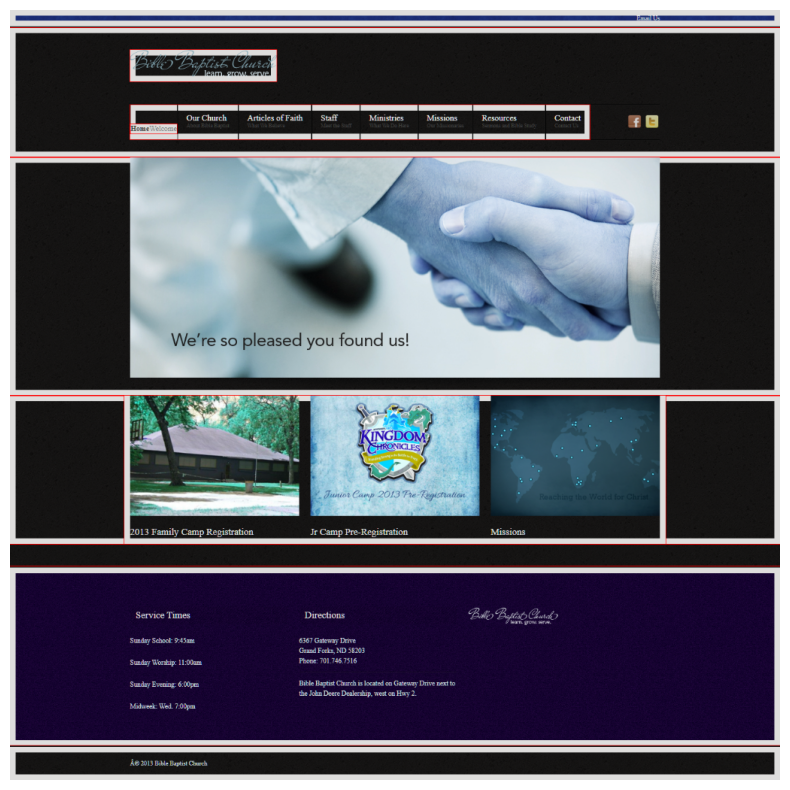

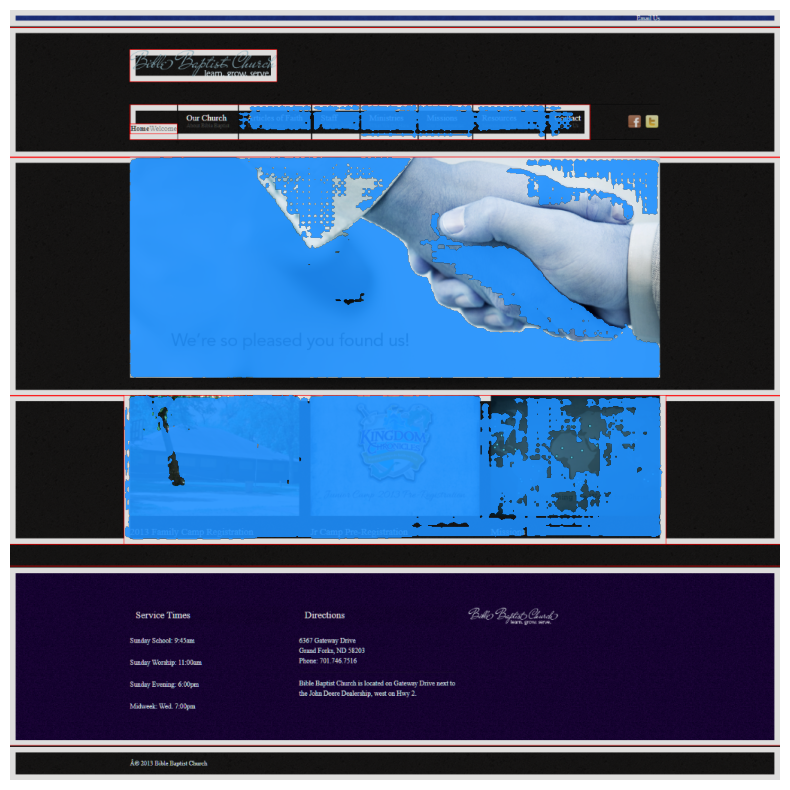

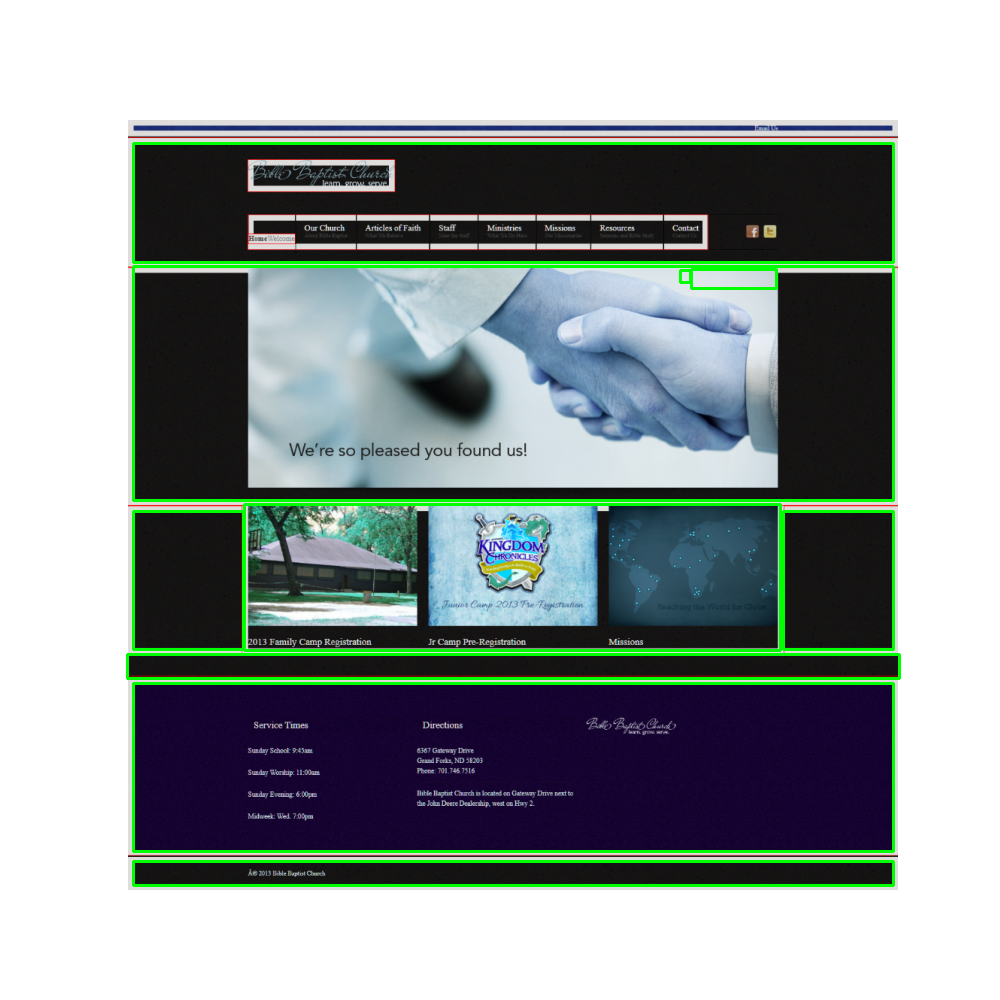

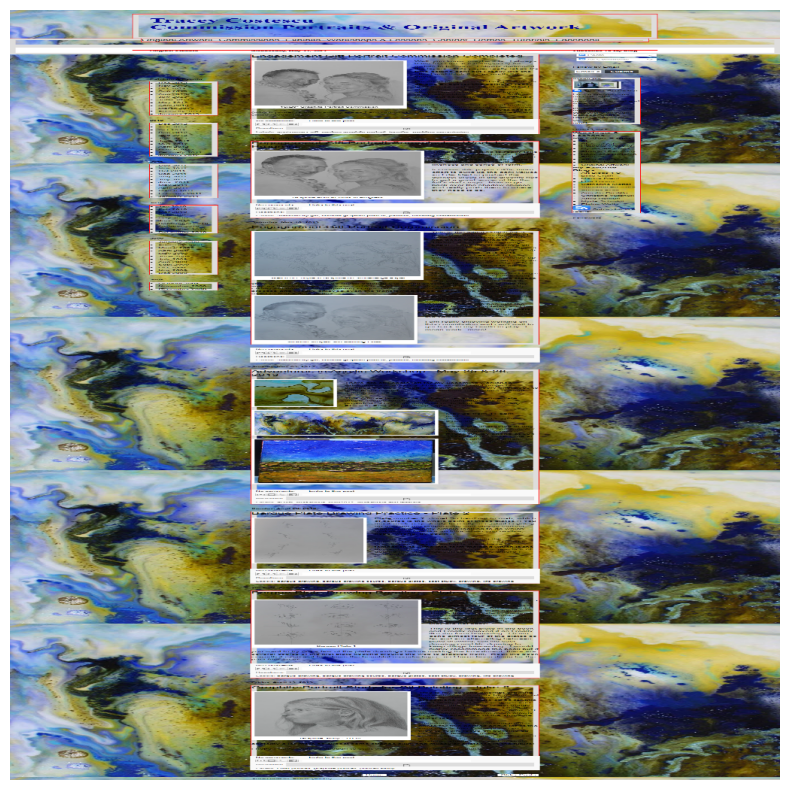

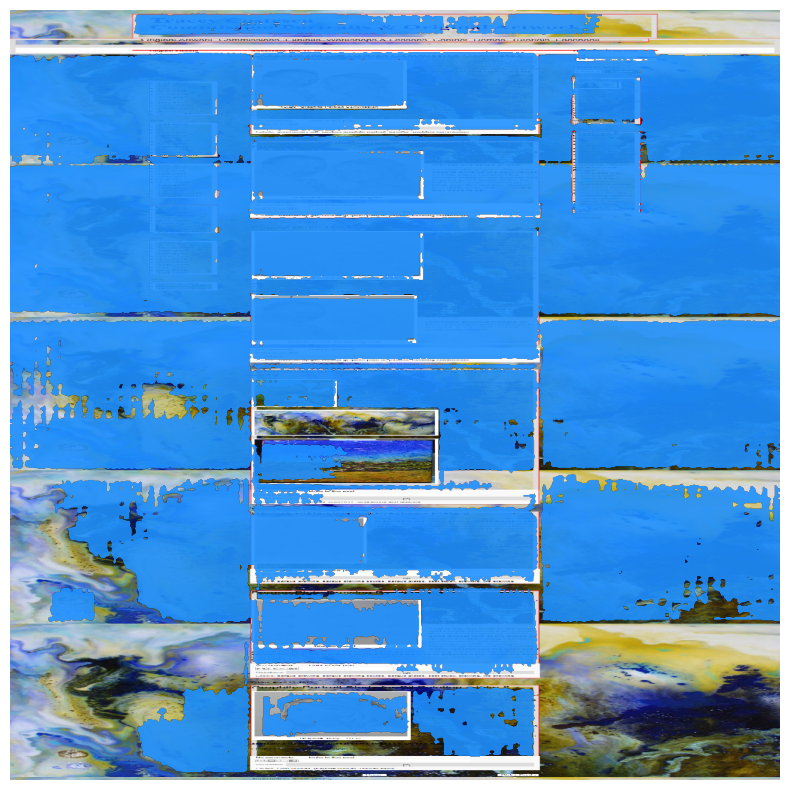

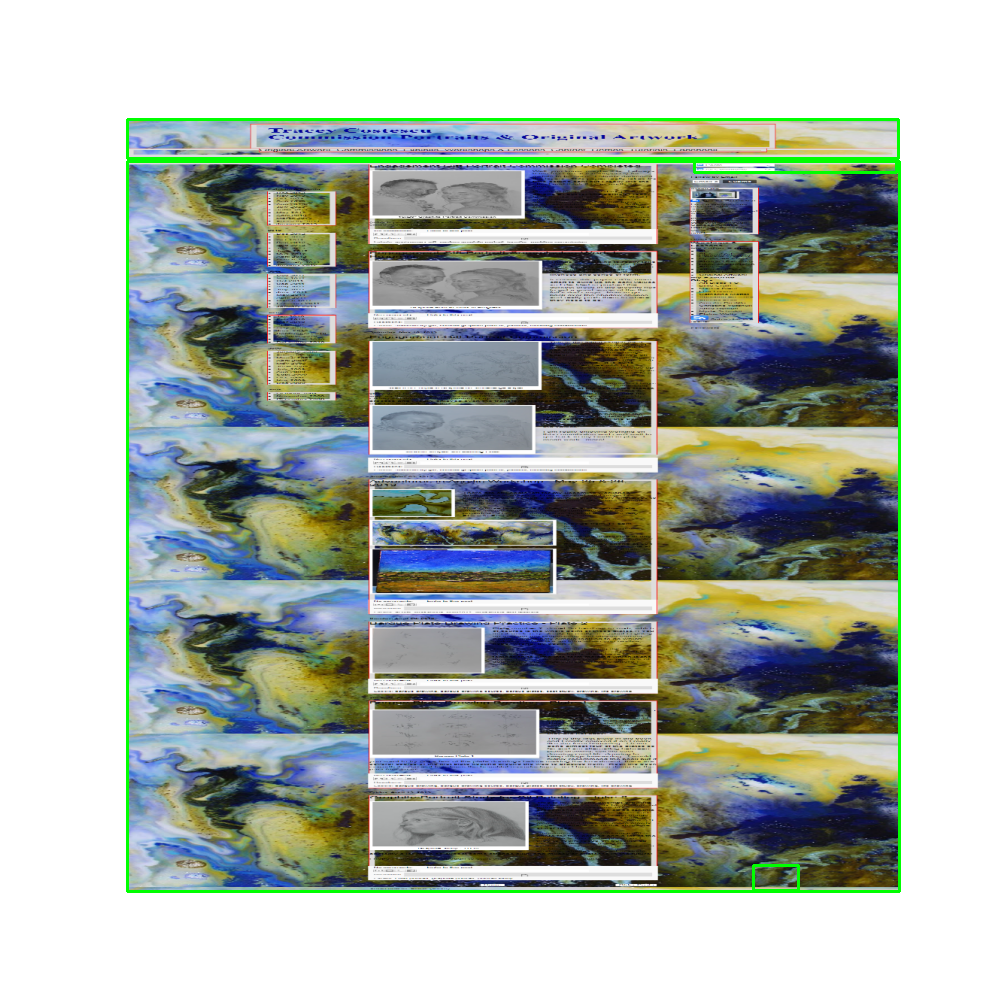

Results saved to results.csv


In [30]:
if __name__ == "__main__":

    # Checkpoint for SAM model
    checkpoint = "sam_vit_h_4b8939.pth"

    # Set directory path for Colab (or your local path)
    directory_path = "/content/random"  # Adjust the path accordingly

    uploader = ImageUploader(directory_path)
    uploader.load_images()
    images, image_names = uploader.get_images()



    results = []

    for img, name in zip(images, image_names):

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


        # Initialize MainProcessor for the current URL
        processor = MainProcessor(checkpoint)
        # Process the URL to segment paragraphs and get results
        number_of_cluster, final_boxes, ocr_results = processor.process(img)
        # Add the result to the results list
        results.append([name, number_of_cluster, final_boxes,ocr_results])

    # Save the results to a CSV file
    with open('results.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Image Name', 'Number of Clusters', 'Bounding Boxes','Boxes with text'])
      for result in results:
          writer.writerow(result)
    print("Results saved to results.csv")